<a href="https://colab.research.google.com/github/Daivar/Deep_Learning_Models/blob/main/CIFAR10_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import matplotlib.pyplot as plt

import multiprocessing as mp
from multiprocessing import Process, Pool, set_start_method
from torch.autograd import Variable

import unittest
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [23]:
mean = [0.49140126, 0.4821608,  0.44652855]
std = [0.24703369, 0.24348529, 0.26158836]

In [24]:
train_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [25]:
trainset = torchvision.datasets.CIFAR10(root='datasets/cifar10/train',
                                        train=True,
                                        download=True,
                                        transform=train_transform)

Files already downloaded and verified


In [26]:
testset = torchvision.datasets.CIFAR10(root='datasets/cifar10/train',
                                       train=False,
                                       download=True)
                                       # transform=test_transform)

Files already downloaded and verified


In [27]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=8,
                                          shuffle=True,
                                          num_workers=2)

In [28]:
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=8,
                                         shuffle=False,
                                         num_workers=2)

In [29]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets/cifar10/train
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.49140126, 0.4821608, 0.44652855], std=[0.24703369, 0.24348529, 0.26158836])
           )

In [30]:
# Using the dataloaders from Pytorch it's very easy to inspect the labels / classification classes
class_names = trainset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [31]:
img, label = iter(trainloader).next()

In [32]:
img.shape

torch.Size([8, 3, 32, 32])

In [33]:
# these are the labels for each image in the batch
label

tensor([3, 8, 6, 9, 4, 9, 2, 3])

In [34]:
for l in label:
  print(str(l) + " : " + class_names[l])

tensor(3) : cat
tensor(8) : ship
tensor(6) : frog
tensor(9) : truck
tensor(4) : deer
tensor(9) : truck
tensor(2) : bird
tensor(3) : cat


In [35]:
in_size = 3

hid1_size = 16
hid2_size = 32

out1_size = 400
out2_size = 10

k_conv_size = 5 # try 6 and 4

In [36]:
in_size = 3

hid1_size = 32 #original: 16
hid2_size = 32 #original: 32

out1_size = 1000
out2_size = 10

k_conv_size = 5 # try 6 and 4

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size),
            nn.BatchNorm2d(hid1_size),
            # nn.ReLU(), # nn.Sigmoid() , nn.Tanh() , nn.ELU()
            nn.ELU(),
            # nn.MaxPool2d(kernel_size=2)) # nn.MaxPool2d() , nn.AvgPool2d() , nn.LPPool2d()
            # nn.LPPool2d(1.5, kernel_size=2)) # <---- nn.LPPool2d(1.5, kernel_size=2)) does not work! Why is that?
            nn.AvgPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, k_conv_size),
            nn.BatchNorm2d(hid2_size),
            # nn.ReLU(),
            nn.ELU(),
            # nn.MaxPool2d(kernel_size=2))
            # nn.LPPool2d(1.5, kernel_size=2))
            nn.AvgPool2d(kernel_size=2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hid2_size * k_conv_size * k_conv_size, out1_size),
            # nn.ReLU(),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(out1_size, out2_size)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1) # flatten
        out = self.layer3(out)
        return F.log_softmax(out, dim=-1)

In [37]:
t = torch.tensor([[[-1,0],[5500,1]]])
print(t.shape)
nn.LPPool2d(1.5, kernel_size=2)(t)
# print(t.shape)

torch.Size([1, 2, 2])


tensor([[[nan]]])

In [38]:
model = ConvNet()

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [40]:
model.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Linear(in_features=800, out_features=1000, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1000, out_features=10, bias=True)
  )
)

In [41]:
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
total_step = len(trainloader)
num_epochs = 8
loss_values = list()

In [43]:
%%time
# Notice that training now takes much longer, since the images are bigger, RGB
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward() # gradients
        optimizer.step() # updates the model params
        if (i+1) % 2000 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
              .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            loss_values.append(loss.item())

print('Finished Training')

Epoch [1/8], Step [2000/6250], Loss: 1.2335
Epoch [1/8], Step [4000/6250], Loss: 1.6733
Epoch [1/8], Step [6000/6250], Loss: 1.6308
Epoch [2/8], Step [2000/6250], Loss: 1.2127
Epoch [2/8], Step [4000/6250], Loss: 1.4164
Epoch [2/8], Step [6000/6250], Loss: 0.5391
Epoch [3/8], Step [2000/6250], Loss: 0.6880
Epoch [3/8], Step [4000/6250], Loss: 1.1689
Epoch [3/8], Step [6000/6250], Loss: 1.2429
Epoch [4/8], Step [2000/6250], Loss: 0.3809
Epoch [4/8], Step [4000/6250], Loss: 0.6231
Epoch [4/8], Step [6000/6250], Loss: 1.1667
Epoch [5/8], Step [2000/6250], Loss: 0.6821
Epoch [5/8], Step [4000/6250], Loss: 1.7543
Epoch [5/8], Step [6000/6250], Loss: 1.0669
Epoch [6/8], Step [2000/6250], Loss: 0.6942
Epoch [6/8], Step [4000/6250], Loss: 1.0349
Epoch [6/8], Step [6000/6250], Loss: 0.8945
Epoch [7/8], Step [2000/6250], Loss: 0.8157
Epoch [7/8], Step [4000/6250], Loss: 1.8488
Epoch [7/8], Step [6000/6250], Loss: 0.6509
Epoch [8/8], Step [2000/6250], Loss: 0.8835
Epoch [8/8], Step [4000/6250], L

Text(0, 0.5, 'Loss')

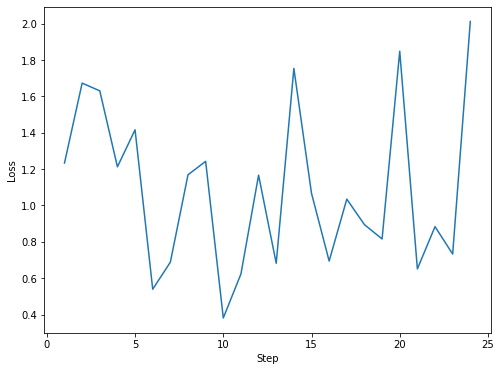

In [54]:
# Evaluate

x = (range(1, num_epochs * 3 + 1))
plt.figure(figsize = (8, 6))
plt.plot(x, loss_values)
plt.xlabel('Step')
plt.ylabel('Loss')

In [ ]:
model.eval() # turn off the batch norm and dropout

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the 10000 test images: {}%'.format(100 * correct / total))

In [46]:
sample_img, _ = testset[23]
sample_img = np.transpose(sample_img, (1, 2, 0))

In [47]:
m, M = sample_img.min(), sample_img.max()
print(m)
print(M)

# shift / scale the values so they would be between 0 and 1 centered at 0.5
# ... if you don't do that, matplotlib will clip the value
sample_img = (sample_img - m) / (M - m)

0
255


In [48]:
print(sample_img.min())
print(sample_img.max())

0.0
1.0


In [49]:
import PIL.ImageOps
from PIL import Image
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [50]:
!wget -O y.jpg https://images-na.ssl-images-amazon.com/images/I/61Wu%2Bj43w9L._AC_SX679_.jpg

--2021-12-28 06:43:24--  https://images-na.ssl-images-amazon.com/images/I/61Wu%2Bj43w9L._AC_SX679_.jpg
Resolving images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)... 151.101.1.16, 151.101.65.16, 151.101.129.16, ...
Connecting to images-na.ssl-images-amazon.com (images-na.ssl-images-amazon.com)|151.101.1.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28850 (28K) [image/jpeg]
Saving to: ‘y.jpg’

y.jpg               100%[===================>]  28.17K  --.-KB/s    in 0s      

2021-12-28 06:43:24 (85.4 MB/s) - ‘y.jpg’ saved [28850/28850]



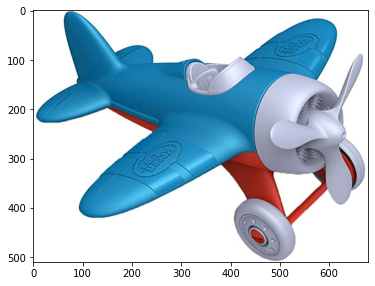

(510, 679, 3)
[0.49140126, 0.4821608, 0.44652855]
[0.24703369, 0.24348529, 0.26158836]


In [51]:
# Load the image
image_name = "y.jpg"
img = Image.open(image_name)
img = np.asarray(img)

plt.figure(figsize = (6, 6))
plt.imshow(img)
plt.show()


# Calculate per-chanell mean and stddev
# mean = img.mean(axis=(0, 1))
# stddev = img.std(axis=(0, 1))

mean = [0.49140126, 0.4821608,  0.44652855]
stddev = [0.24703369, 0.24348529, 0.26158836]

print(img.shape)
print(mean)
print(stddev)

In [52]:
# Define and apply the transformation
t = transforms.Compose([
    transforms.Resize((32, 32), Image.HAMMING),
    transforms.ToTensor(),
    transforms.Normalize(mean,stddev)
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
